# Julia Deep Learning

https://fluxml.ai/

https://github.com/FluxML/model-zoo

In [10]:
using Flux
using CuArrays
using Plots
using Plots.PlotMeasures

CuArrays.allowscalar(false)
pyplot()

Plots.PyPlotBackend()

## MNIST Dataset

In [2]:
MNISTspec = (
    input_size = (28, 28, 1),
    num_classes = 10,
    train_size = 60000,
    test_size = 10000,
)
batch_size = 256;

In [17]:
function load_mnist(split=:train)
    mnist = Flux.Data.MNIST
    
    images = mnist.images(split) # Array with N images of 28x28 8-bits gray
    labels = mnist.labels(split) # Array with N labels scalar 0-9
    
    return images, labels
end

X_train, y_train = load_mnist(:train)
X_test, y_test = load_mnist(:test)

println("Train data\n")
println("X:\n",
        "\ntype = ", typeof(X_train),
        "\nsize = ", size(X_train),
        "\nshape = ", size(X_train[1]),
        "\n")
println("y:\n",
        "\ntype = ", typeof(y_train),
        "\nsize = ", size(y_train),
        "\n\n")

println("Test data\n")
println("X:\n",
        "\ntype = ", typeof(X_test),
        "\nsize = ", size(X_test),
        "\nshape = ", size(X_test[1]),
        "\n")
println("y:\n",
        "\ntype = ", typeof(y_test),
        "\nsize = ", size(y_test))

Train data

X:

type = Array{Array{Gray{FixedPointNumbers.Normed{UInt8,8}},2},1}
size = (60000,)
shape = (28, 28)

y:

type = Array{Int64,1}
size = (60000,)


Test data

X:

type = Array{Array{Gray{FixedPointNumbers.Normed{UInt8,8}},2},1}
size = (10000,)
shape = (28, 28)

y:

type = Array{Int64,1}
size = (10000,)


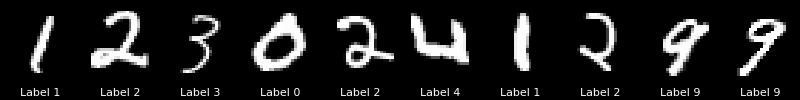

In [18]:
plot_digit(x, y) = plot(x, xlabel= y!==nothing ? "Label $(y)" : "",
                        guidefontsize=8, legend=false, margin=0mm, link=:both,
                        ticks=nothing, border=:none)
function plot_digits(x, y=nothing; size=(800, 100), layout=(1, length(x)))
    plots = map(1:prod(layout)) do i
        xi = x[i]
        yi = y !== nothing ? y[i] : nothing
        plot_digit(xi, yi)
    end
    plot(plots..., layout=layout, size=size, bg_color="black", fg_color="white")
end

sample_indices = rand(1:length(X_train), 10)
X_sample = X_train[sample_indices]
y_sample = y_train[sample_indices]
plot_digits(X_sample, y_sample)

In [41]:
function compute_num_channels(image)
    color_type = eltype(image)
    if color_type <: Gray
        return 1
    elseif color_type <: RGB
        return 3
    else
        error("Unknown color type: $(color_type)")
    end
end

function make_whcn_format(images)
    width, height = size(images[1])
    num_channels = compute_num_channels(images[1])
    images_array = map(images) do image
        Float32.(reshape(image, width, height, num_channels, 1))
    end
    images_tensor = cat(images_array...; dims=4)
end

X_whcn = make_whcn_format(X_sample)
println("X (WHCN format):\n",
        "\ntype = ", typeof(X_whcn),
        "\nsize = ", size(X_whcn),
        "\n")

X (WHCN format):

type = Array{Float32,4}
size = (28, 28, 1, 10)



In [45]:
import Flux: onehot

function make_onehot_format(labels, class_vector)
    labels_array = map(labels) do label
        Float32.(onehot(label, class_vector))
    end
    hcat(labels_array...)
end

y_onehot = make_onehot_format(y_sample, 0:9)
println("y (One Hot format):\n",
        "\ntype = ", typeof(y_onehot),
        "\nsize = ", size(y_onehot),
        "\n")

y (One Hot format):

type = Array{Float32,2}
size = (10, 10)



In [54]:
import Flux: onehot
import Base.Iterators: partition

function make_batch(X, y, batch_size)
    num_examples = length(X)
    num_batches = ceil(Int, num_examples / batch_size)
    batch_indices = partition(1:num_examples, batch_size)
    batches = map(batch_indices) do indices
        X_batch = make_whcn_format(X[indices])
        y_batch = make_onehot_format(y[indices], 0:9)
        (X_batch, y_batch)
    end
    return batches
end

batch_size = 256
train_data = make_batch(X_train, y_train, batch_size)

println("Train Data: type=$(typeof(train_data)), size=$(size(train_data))")

Train Data: type=Array{Tuple{Array{Float32,4},Array{Float32,2}},1}, size=(235,)


In [55]:
size(train_data[1][1])

(28, 28, 1, 256)

In [56]:
size(train_data[end][1])

(28, 28, 1, 96)

In [57]:
size(train_data[1][2])

(10, 256)

In [58]:
size(train_data[end][2])

(10, 96)

In [9]:
test_data = make_batch(load_mnist(:test)..., MNISTspec.test_size)[1]

println("Test Data: type=$(typeof(test_data))")
println(size(test_data[1]))
println(size(test_data[2]))

Test Data: type=Tuple{Array{Float32,4},Array{Float32,2}}
(28, 28, 1, 10000)
(10, 10000)


## Keras-like API

In [10]:
struct Flatten end

(::Flatten)(x) = reshape(x, :, size(x)[end])

struct Reshape
    dims
end

(layer::Reshape)(x) = reshape(x, layer.dims..., size(x)[end])

## MLP

https://github.com/FluxML/model-zoo/blob/master/vision/mnist/mlp.jl

In [49]:
input_size = MNISTspec.input_size
output_size = MNISTspec.num_classes
hidden_size = 500

model = Chain(
    Flatten(),
    Dense(prod(input_size), hidden_size, relu),
    Dense(hidden_size, output_size),
    softmax,
)

model = gpu(model)

model

Chain(Flatten(), Dense(784, 500, relu), Dense(500, 10), softmax)

In [50]:
let
    x1 = gpu(train_data[1][1])
    display(model(x1))
end

10×256 CuArray{Float32,2,Nothing}:
 0.178659   0.133649   0.152569   …  0.173248   0.16839    0.153217
 0.0885137  0.0622111  0.0637348     0.0587575  0.0562047  0.0878141
 0.14292    0.077084   0.134308      0.0889326  0.112031   0.0821616
 0.0909256  0.128032   0.126365      0.124029   0.0648823  0.0900216
 0.0826455  0.158021   0.102386      0.117134   0.106272   0.167001
 0.108827   0.0820533  0.0725608  …  0.0547967  0.0582826  0.0918432
 0.0964257  0.119808   0.100351      0.128332   0.175979   0.0916331
 0.118307   0.142695   0.106841      0.121777   0.118184   0.124711
 0.0493862  0.0398466  0.0531612     0.0541759  0.0570676  0.0557162
 0.0433903  0.0566     0.087723      0.0788175  0.0827072  0.0558819

In [51]:
import Flux: logitcrossentropy, onecold
import Statistics: mean

function loss(x, y)
    logits = model[1:end-1](x)
    return logitcrossentropy(logits, y)
end

function accuracy(x, y)
    ŷ = model(x)
    return mean(onecold(cpu(ŷ)) .== onecold(cpu(y)))
end


let
    println("Train (batch 1)\n")
    
    data1 = gpu(train_data[1])
    loss_ = loss(data1...)
    acc_ = accuracy(data1...)

    println("Loss: ", loss_)
    println("Accuracy: ", acc_)
end

println()

let
    println("Test\n")

    data = gpu(test_data)
    loss_ = loss(data...)
    acc_ = accuracy(data...)

    println("Loss: ", loss_)
    println("Accuracy: ", acc_)
end

Train (batch 1)

Loss: 2.3730845
Accuracy: 0.1015625

Test

Loss: 2.3558664
Accuracy: 0.0985


In [30]:
import Flux: train!
import BSON: bson
import Printf: @printf

optimizer = ADAM(0.001)

best_acc = 0.0
last_improvement = 0
for epoch_idx in 1:100
    # Train for a single epoch
    for i in 1:length(train_data)
        let data = gpu(train_data[i])
            train!(loss, params(model), [data], optimizer)
        end
    end
    
    # Calculate accuracy:
    acc = let data = gpu(test_data)
        accuracy(data...)
    end
    
    @printf("[%d] Test accuracy: %.4f\n", epoch_idx, acc)

    # If our accuracy is good enough, quit out.
    if acc >= 0.999
        println(" -> Early-exiting: We reached our target accuracy of 99.9%")
        break
    end

    # If this is the best accuracy we've seen so far, save the model out
    if acc >= best_acc
        println(" -> New best accuracy! Saving model out to mlp_mnist.bson")
        bson("mlp_mnist.bson", model = cpu(model), epoch = epoch_idx)
        best_acc = acc
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in 5 epochs, drop our learning rate:
    if epoch_idx - last_improvement >= 5 && optimizer.eta > 1e-6
        optimizer.eta /= 10.0
        println(" -> Haven't improved in a while, dropping learning rate to $(optimizer.eta)!")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement >= 10
        println(" -> We're calling this converged.")
        break
    end
end

[1] Test accuracy: 0.9495
 -> New best accuracy! Saving model out to mlp_mnist.bson
[2] Test accuracy: 0.9643
 -> New best accuracy! Saving model out to mlp_mnist.bson
[3] Test accuracy: 0.9703
 -> New best accuracy! Saving model out to mlp_mnist.bson
[4] Test accuracy: 0.9719
 -> New best accuracy! Saving model out to mlp_mnist.bson
[5] Test accuracy: 0.9728
 -> New best accuracy! Saving model out to mlp_mnist.bson
[6] Test accuracy: 0.9748
 -> New best accuracy! Saving model out to mlp_mnist.bson
[7] Test accuracy: 0.9754
 -> New best accuracy! Saving model out to mlp_mnist.bson
[8] Test accuracy: 0.9767
 -> New best accuracy! Saving model out to mlp_mnist.bson
[9] Test accuracy: 0.9764
[10] Test accuracy: 0.9777
 -> New best accuracy! Saving model out to mlp_mnist.bson
[11] Test accuracy: 0.9779
 -> New best accuracy! Saving model out to mlp_mnist.bson
[12] Test accuracy: 0.9778
[13] Test accuracy: 0.9784
 -> New best accuracy! Saving model out to mlp_mnist.bson
[14] Test accuracy: 

In [46]:
model = nothing

GC.gc()

In [47]:
import BSON: load

model = load("mlp_mnist.bson")[:model]
model = gpu(model)

model

Chain(Flatten(), Dense(784, 500, relu), Dense(500, 10), softmax)

In [48]:
let
    println("Test\n")

    data = gpu(test_data)
    loss_ = loss(data...)
    acc_ = accuracy(data...)

    println("Loss: ", loss_)
    println("Accuracy: ", acc_)
end

Test

Loss: 0.07115936
Accuracy: 0.9825


## CNN

https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl

In [71]:
input_size = MNISTspec.input_size
output_size = MNISTspec.num_classes

conv1_kernel_size = (3, 3)
conv1_filter_size = input_size[end] => 16
conv1_pad = (1, 1)
pool1_size = (2, 2)

conv2_kernel_size = (3, 3)
conv2_filter_size = conv1_filter_size.second => 32
conv2_pad = (1, 1)
pool2_size = (2, 2)

conv3_kernel_size = (3, 3)
conv3_filter_size = conv2_filter_size.second => 32
conv3_pad = (1, 1)
pool3_size = (2, 2)

fc1_size = prod(input_size[1:2] .÷ pool1_size .÷ pool2_size .÷ pool3_size) * conv3_filter_size.second

model = Chain(
    Conv(conv1_kernel_size, conv1_filter_size, pad=conv1_pad, relu),
    MaxPool(pool1_size),

    Conv(conv2_kernel_size, conv2_filter_size, pad=conv2_pad, relu),
    MaxPool(pool2_size),

    Conv(conv3_kernel_size, conv3_filter_size, pad=conv3_pad, relu),
    MaxPool(pool3_size),
    
    Flatten(),
    Dense(fc1_size, output_size),
    softmax,
)

model = gpu(model)

model

Chain(Conv((3, 3), 1=>16, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 16=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 32=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Flatten(), Dense(288, 10), softmax)

In [72]:
let
    x1 = gpu(train_data[1][1])
    display(model(x1))
end

10×256 CuArray{Float32,2,Nothing}:
 0.115904   0.118493   0.113906   …  0.124623   0.109827   0.113278
 0.132425   0.146244   0.122483      0.146046   0.131634   0.124296
 0.133791   0.149875   0.132157      0.142459   0.150433   0.158189
 0.0849604  0.0776478  0.0858348     0.0803556  0.0850954  0.0844602
 0.100588   0.105827   0.0955029     0.099066   0.110376   0.105902
 0.078658   0.0683121  0.0817824  …  0.0698694  0.0766497  0.0738479
 0.0884483  0.086134   0.0903206     0.0800639  0.0809841  0.0793109
 0.0819794  0.0778961  0.0776319     0.0776626  0.0779353  0.0763676
 0.0962854  0.087108   0.112195      0.0912792  0.0920803  0.0926253
 0.0869617  0.0824621  0.0881867     0.0885751  0.0849853  0.0917228

In [73]:
import Flux: logitcrossentropy, onecold
import Statistics: mean

function loss_noise(x, y)
    x_aug = x .+ 0.1f0 * gpu(randn(eltype(x), size(x)))
    logits = model[1:end-1](x)
    return logitcrossentropy(logits, y)
end

function accuracy(x, y)
    ŷ = model(x)
    return mean(onecold(cpu(ŷ)) .== onecold(cpu(y)))
end


let
    println("Train (batch 1)\n")
    
    data1 = gpu(train_data[1])
    loss_ = loss_noise(data1...)
    acc_ = accuracy(data1...)

    println("Loss: ", loss_)
    println("Accuracy: ", acc_)
end

Train (batch 1)

Loss: 2.3100429
Accuracy: 0.0703125


In [16]:
import Flux: train!
import BSON: bson
import Printf: @printf

optimizer = ADAM(0.001)

best_acc = 0.0
last_improvement = 0
for epoch_idx in 1:100
    # Train for a single epoch
    for i in 1:length(train_data)
        let data = gpu(train_data[i])
            train!(loss_noise, params(model), [data], optimizer)
        end
    end
    
    # Calculate accuracy:
    acc = let data = gpu(test_data)
        accuracy(data...)
    end
    
    @printf("[%d] Test accuracy: %.4f\n", epoch_idx, acc)
    
    # If our accuracy is good enough, quit out.
    if acc >= 0.999
        println(" -> Early-exiting: We reached our target accuracy of 99.9%")
        break
    end

    # If this is the best accuracy we've seen so far, save the model out
    if acc >= best_acc
        println(" -> New best accuracy! Saving model out to cnn_mnist.bson")
        bson("cnn_mnist.bson", model = cpu(model), epoch = epoch_idx)
        best_acc = acc
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in 5 epochs, drop our learning rate:
    if epoch_idx - last_improvement >= 5 && optimizer.eta > 1e-6
        optimizer.eta /= 10.0
        println(" -> Haven't improved in a while, dropping learning rate to $(optimizer.eta)!")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement >= 10
        println(" -> We're calling this converged.")
        break
    end
end

[1] Test accuracy: 0.9511
 -> New best accuracy! Saving model out to cnn_mnist.bson
[2] Test accuracy: 0.9744
 -> New best accuracy! Saving model out to cnn_mnist.bson
[3] Test accuracy: 0.9800
 -> New best accuracy! Saving model out to cnn_mnist.bson
[4] Test accuracy: 0.9803
 -> New best accuracy! Saving model out to cnn_mnist.bson
[5] Test accuracy: 0.9826
 -> New best accuracy! Saving model out to cnn_mnist.bson
[6] Test accuracy: 0.9837
 -> New best accuracy! Saving model out to cnn_mnist.bson
[7] Test accuracy: 0.9857
 -> New best accuracy! Saving model out to cnn_mnist.bson
[8] Test accuracy: 0.9864
 -> New best accuracy! Saving model out to cnn_mnist.bson
[9] Test accuracy: 0.9872
 -> New best accuracy! Saving model out to cnn_mnist.bson
[10] Test accuracy: 0.9872
 -> New best accuracy! Saving model out to cnn_mnist.bson
[11] Test accuracy: 0.9878
 -> New best accuracy! Saving model out to cnn_mnist.bson
[12] Test accuracy: 0.9880
 -> New best accuracy! Saving model out to cnn_

In [41]:
model = nothing

GC.gc()

In [42]:
import BSON: load

model = load("cnn_mnist.bson")[:model]
model = gpu(model)

model

Chain(Conv((3, 3), 1=>16, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 16=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 32=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Flatten(), Dense(288, 10), softmax)

In [44]:
let
    println("Test\n")

    data = gpu(test_data)
    loss_ = loss_noise(data...)
    acc_ = accuracy(data...)

    println("Loss: ", loss_)
    println("Accuracy: ", acc_)
end

Test

Loss: 0.02866702
Accuracy: 0.992


## Autoencoder

https://github.com/FluxML/model-zoo/blob/master/vision/mnist/autoencoder.jl

In [63]:
input_size = MNISTspec.input_size
hidden_size = 500
encoded_size = 50

encoder = Chain(
    Flatten(),
    Dense(prod(input_size), hidden_size, leakyrelu),
    Dense(hidden_size, encoded_size, leakyrelu),
)

decoder = Chain(
    Dense(encoded_size, hidden_size, leakyrelu),
    Dense(hidden_size, prod(input_size), leakyrelu),
    Reshape(input_size),
)

model = Chain(encoder, decoder)

model = gpu(model)

model

Chain(Chain(Flatten(), Dense(784, 500, leakyrelu), Dense(500, 50, leakyrelu)), Chain(Dense(50, 500, leakyrelu), Dense(500, 784, leakyrelu), Reshape((28, 28, 1))))

In [64]:
let
    x1 = gpu(train_data[1][1])
    x̂1 = model(x1)
    println("x : type=$(typeof(x1)), size=$(size(x1))")
    println("x̂ : type=$(typeof(x̂1)), size=$(size(x̂1))")
end

x : type=CuArray{Float32,4,Nothing}, size=(28, 28, 1, 256)
x̂ : type=CuArray{Float32,4,CuArray{Float32,2,Nothing}}, size=(28, 28, 1, 256)


In [65]:
function loss(x)
    x̂ = model(x)
    err = x̂ .- x
    N = length(x)
    return sum(err .* err) / N
end

let
    println("Train (batch 1)\n")
    x1 = gpu(train_data[1][1])
    loss_ = loss(x1)
    println("Loss: ", loss_)
end

println()

let
    println("Test\n")
    data = gpu(test_data[1])
    loss_ = loss(data)
    println("Loss: ", loss_)
end

Train (batch 1)

Loss: 0.10489251

Test

Loss: 0.108690426


In [23]:
import Flux: train!
import BSON: bson
import Printf: @printf

optimizer = ADAM(0.001)

best_loss = Inf
last_improvement = 0
for epoch_idx in 1:100
    # Train for a single epoch
    for i in 1:length(train_data)
        let data = gpu(train_data[i][1])
            train!(loss, params(model), [(data,)], optimizer)
        end
    end
    
    # Calculate accuracy:
    loss_ = let data = gpu(test_data[1])
        loss(data)
    end
    
    @printf("[%d] Test loss: %.4f\n", epoch_idx, loss_)
    
    # If this is the best accuracy we've seen so far, save the model out
    if loss_ <= best_loss
        println(" -> New best loss! Saving model out to ae_mnist.bson")
        bson("ae_mnist.bson", model = cpu(model), epoch = epoch_idx)
        best_loss = loss_
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in 5 epochs, drop our learning rate:
    if epoch_idx - last_improvement >= 5 && optimizer.eta > 1e-6
        optimizer.eta /= 10.0
        println(" -> Haven't improved in a while, dropping learning rate to $(optimizer.eta)!")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement >= 10
        println(" -> We're calling this converged.")
        break
    end
end

[1] Test loss: 0.0119
 -> New best loss! Saving model out to ae_mnist.bson
[2] Test loss: 0.0094
 -> New best loss! Saving model out to ae_mnist.bson
[3] Test loss: 0.0085
 -> New best loss! Saving model out to ae_mnist.bson
[4] Test loss: 0.0078
 -> New best loss! Saving model out to ae_mnist.bson
[5] Test loss: 0.0073
 -> New best loss! Saving model out to ae_mnist.bson
[6] Test loss: 0.0068
 -> New best loss! Saving model out to ae_mnist.bson
[7] Test loss: 0.0066
 -> New best loss! Saving model out to ae_mnist.bson
[8] Test loss: 0.0063
 -> New best loss! Saving model out to ae_mnist.bson
[9] Test loss: 0.0061
 -> New best loss! Saving model out to ae_mnist.bson
[10] Test loss: 0.0059
 -> New best loss! Saving model out to ae_mnist.bson
[11] Test loss: 0.0058
 -> New best loss! Saving model out to ae_mnist.bson
[12] Test loss: 0.0056
 -> New best loss! Saving model out to ae_mnist.bson
[13] Test loss: 0.0056
 -> New best loss! Saving model out to ae_mnist.bson
[14] Test loss: 0.005

In [66]:
model = nothing

GC.gc()

In [69]:
import BSON: load

model = load("ae_mnist.bson")[:model]
model = gpu(model)

model

Chain(Chain(Flatten(), Dense(784, 500, leakyrelu), Dense(500, 50, leakyrelu)), Chain(Dense(50, 500, leakyrelu), Dense(500, 784, leakyrelu), Reshape((28, 28, 1))))

In [70]:
let
    println("Test\n")
    data = gpu(test_data[1])
    loss_ = loss(data)
    println("Loss: ", loss_)
end

Test

Loss: 0.00367186
